
#Описание




Дообучение модели Stable Diffusion на новой выборке данных, сохраняя знания, полученные на предыдущем этапе обучения.



Шаги:

Загрузка предобученной модели: Используется модель CompVis/stable-diffusion-v1-4.

Загрузка и предобработка данных: Датасет загружается из CSV файла и предобрабатывается.

Настройка аргументов для обучения: Определяются параметры обучения, такие как размер батча, количество эпох и скорость обучения.

Настройка тренера: Создается объект тренера для дообучения модели.

Дообучение модели: Модель дообучается на новом датасете.

Сохранение дообученной модели: Дообученная модель сохраняется локально.

Stable Diffusion v1-4 обучалась на датасете LAION-Aesthetics v2 5+12. Этот датасет был создан на основе более крупного набора данных LAION-5B, который включает в себя миллиарды изображений и их текстовых описаний3. Модель была дообучена на 225 тысячах шагов с разрешением 512x512 пикселей12.

Датасет для дообучения -  датасет foodi-ml-dataset https://github.com/Glovo/foodi-ml-dataset

Набор данных Food Drinks and Groceries Images Multi Lingual (FooDI-ML) содержит более 1,5 млн уникальных изображений и более 9,5 млн названий магазинов, названий продуктов, описаний и разделов коллекций, собранных из приложения Glovo. Доступные данные соответствуют продуктам питания, напиткам и продуктам из более чем 37 стран Европы, Ближнего Востока, Африки и Латинской Америки. Набор данных охватывает 33 языка, включая 870 тыс. образцов языков стран Восточной Европы и Западной Азии, таких как украинский и казахский, которые до сих пор были недостаточно представлены в общедоступных визуальных лингвистических наборах данных. Набор данных также включает широко распространенные языки, такие как испанский и английский.

# Установка и импорт библиотек

In [1]:
!pip install git+https://github.com/huggingface/diffusers.git

  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-7iwrw2lp
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-7iwrw2lp
  Resolved https://github.com/huggingface/diffusers.git to commit 96c376a5ff201a31d676091a59a011c8c29d095b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.32.0.dev0-py3-none-any.whl size=3120796 sha256=448daf6445958a06121786179632cad8346c4402b94537f558eeafbc169fad6d
  Stored in directory: /tmp/pip-ephem-wheel-cache-sjk0_kcv/wheels/4d/b7/a8/6f9549ceec5daad78675b857ac57d697c387062506520a7b50
Successfully built diffusers
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.31.0
    Uninstalling diffusers-0.31.0:
      Successfully uninstalled diffusers-0.31.0


In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
!pip install pandas

In [4]:
!pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 9.8 MB/s eta 0:00:00


In [5]:
# Установка AWS CLI
#!pip install awscli

In [35]:
import torch
import pickle
import os
import matplotlib.image as mpimg
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch import nn, optim
from torch.cuda.amp import GradScaler, autocast
import tqdm
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline

from transformers import Trainer, TrainingArguments, DefaultDataCollator
from datasets import load_dataset
from PIL import Image

import pandas as pd
import shutil
import boto3

from collections import Counter

# Загрузка модели и формирование датасета для дообучения

In [50]:
# Удаление ранее сохраненной модели
# Путь к папке с сохраненной моделью
model_path = "./stable_diffusion_model"
# Удаление папки с моделью
shutil.rmtree(model_path)

In [51]:
# Загрузка модели из интернета
model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = StableDiffusionPipeline.from_pretrained(model_id)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [23]:
# Генерация изображения по текстовому запросу
prompt_1 = "Space Fantasy Whisky"
image = pipe(prompt_1).images[0]

# Сохранение изображения
image.save("generated_image_1.png")

  0%|          | 0/50 [00:00<?, ?it/s]

In [20]:
# Генерация изображения по текстовому запросу
prompt_2 = "Fairytale Forest Whisky"
image = pipe(prompt_2).images[0]

# Сохранение изображения
image.save("generated_image_2.png")

  0%|          | 0/50 [00:00<?, ?it/s]

In [29]:
# Генерация изображения по текстовому запросу
prompt_3 = "Winter Wonderland Whisky"
image = pipe(prompt_3).images[0]

# Сохранение изображения
image.save("generated_image_3.png")

  0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [52]:
# Сохранение модели локально
pipe.save_pretrained("./stable_diffusion_model")

In [53]:
# Загрузка модели из локального хранилища
pipe = StableDiffusionPipeline.from_pretrained("./stable_diffusion_model")
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
# Копирование CSV файла с данными
#!aws s3 cp s3://glovo-products-dataset-d1c9720d/glovo-foodi-ml-dataset.csv /content/drive/MyDrive/DS_Belhard_2/Homeworks/HW_4/ --no-sign-request

download: s3://glovo-products-dataset-d1c9720d/glovo-foodi-ml-dataset.csv to drive/MyDrive/DS_Belhard_2/Homeworks/HW_4/glovo-foodi-ml-dataset.csv


In [ ]:
# Копирование датасета
#!aws s3 cp --recursive s3://glovo-products-dataset-d1c9720d/dataset /content/drive/MyDrive/DS_Belhard_2/Homeworks/HW_4/dataset --no-sign-request --quiet

In [12]:
# Загрузка датасета
dataset = load_dataset('csv', data_files='/content/drive/MyDrive/DS_Belhard_2/Homeworks/HW_4/glovo-foodi-ml-dataset.csv')

Generating train split: 0 examples [00:00, ? examples/s]

In [13]:
# Получение строки датасета
first_row = dataset['train'][0]
first_row

{'Unnamed: 0': 0,
 'country_code': 'CL',
 'city_code': 'STG',
 'store_name': 'AS_000',
 'product_name': 'Savital Shampoo Keratina Y Sabila 550Ml (0000123592)',
 'collection_section': 'Shampoo',
 'product_description': None,
 'subset': 'train',
 'hash': 3509449892161349181,
 'aux_store': True,
 'HIER': False,
 's3_path': 'dataset/NZTCKFL_0017467_1193055503.png'}

In [15]:
# Получение списка загруженных изображений
loaded_images = os.listdir('/content/drive/MyDrive/DS_Belhard_2/Homeworks/HW_4/dataset')

# Фильтрация строк по загруженным изображениям
filtered_dataset_1 = dataset['train'].filter(lambda x: os.path.basename(x['s3_path']) in loaded_images)

# Подсчет значений 'collection_section'
collection_section_counts = Counter(filtered_dataset_1['collection_section'])

print(collection_section_counts)

Filter:   0%|          | 0/2887444 [00:00<?, ? examples/s]

Counter({'Bebidas': 1494, 'Postres': 570, 'Entrantes': 540, 'Chocolates': 500, 'Gaseosas': 436, 'Jugos': 436, 'Verduras': 301, 'Refrescos': 294, 'Snacks': 292, 'Cervezas': 287, 'Frutas': 283, 'Hamburguesas': 255, 'Vinos': 249, 'Ron': 244, 'Pizzas': 244, 'Ensaladas': 221, 'Shampoo': 219, 'Pollo': 208, 'Dulces': 204, 'Pescado': 199, 'Leche': 199, 'Combos': 193, 'Cigarrillos': 181, 'Otros': 179, 'Fruit juice & flavoured drinks': 177, 'Vino Tinto': 165, 'Whisky': 161, 'Ice cream': 157, 'Tea': 156, 'Desayuno': 156, 'Platos principales': 151, 'Galletitas': 150, 'Preservativos': 148, 'Detergente': 143, 'Cereales': 142, 'Pasta': 137, 'Yoghurt & desserts': 137, 'Cuidado Corporal': 136, 'Gadżety': 136, 'Yogurt': 134, 'Aguas': 132, 'Cervezas Nacionales': 131, 'Helados': 130, 'Agua': 129, 'Salsas': 128, 'Aperitivos': 128, 'Cerdo': 124, 'Cervezas Extranjeras': 123, 'Snacks Salados': 123, 'Cuidado Bucal': 122, 'Galletas': 121, 'Vodka': 121, 'Embutidos': 120, 'Café': 117, 'Pañales': 114, 'ПІЦА': 114,

In [30]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Фильтрация строк по метке 'Whisky'
filtered_dataset_2 = dataset['train'].filter(lambda x: x['collection_section'] == 'Whisky' and os.path.basename(x['s3_path']) in loaded_images)

# Получение списка изображений
Whisky_images = [os.path.basename(x['s3_path']) for x in filtered_dataset_2]

# Путь к папке с изображениями
image_folder = '/content/drive/MyDrive/DS_Belhard_2/Homeworks/HW_4/dataset'

Filter:   0%|          | 0/2887444 [00:00<?, ? examples/s]

In [31]:
# Сохранение списка изображений в файл pkl
with open('Whisky_images.pkl', 'wb') as f:
  pickle.dump(Whisky_images, f)

print("Файл pkl успешно создан!")

Файл pkl успешно создан!


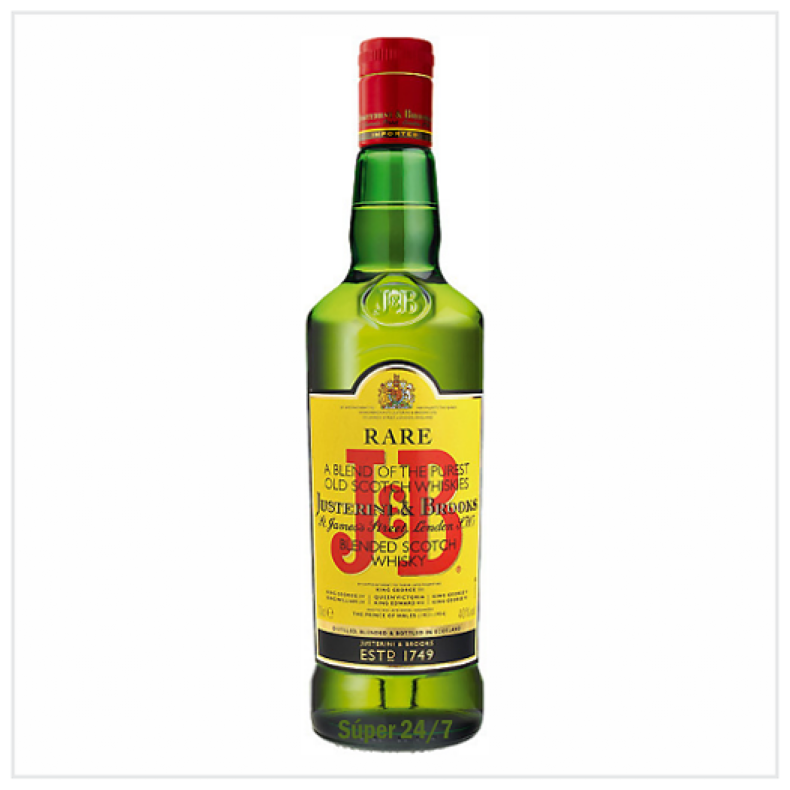

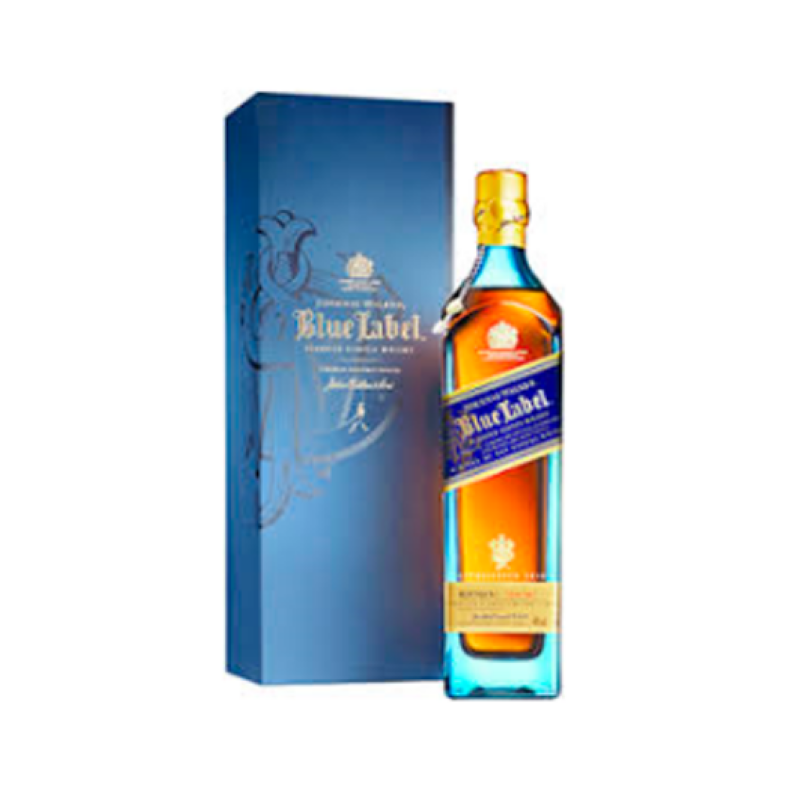

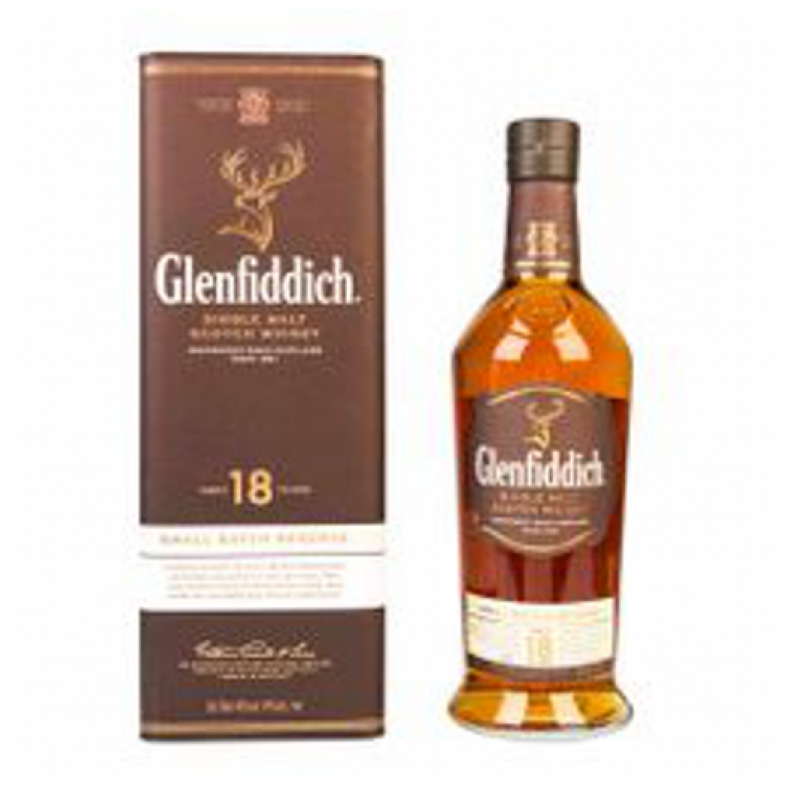

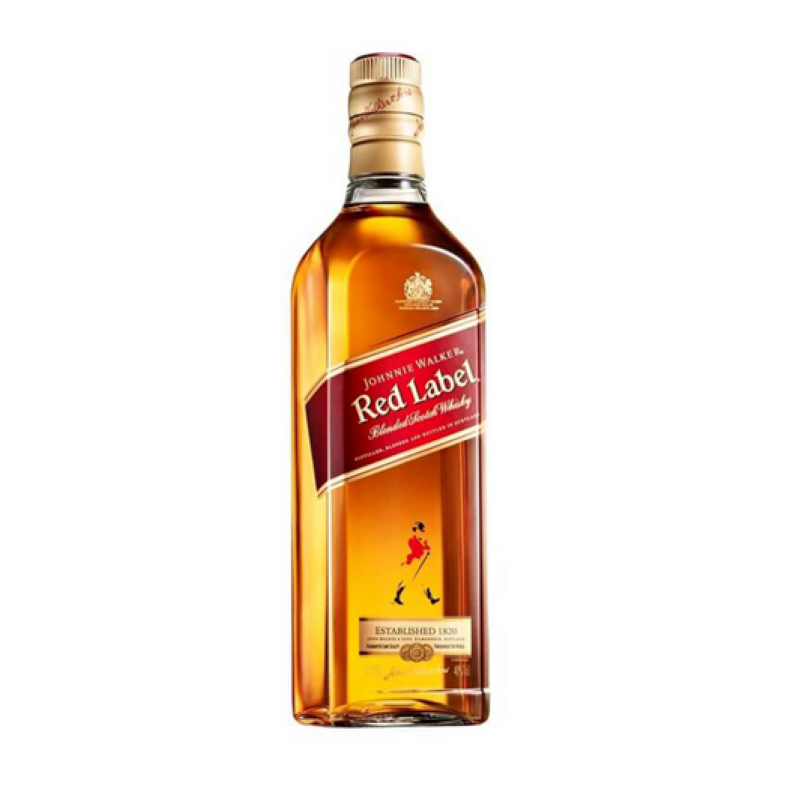

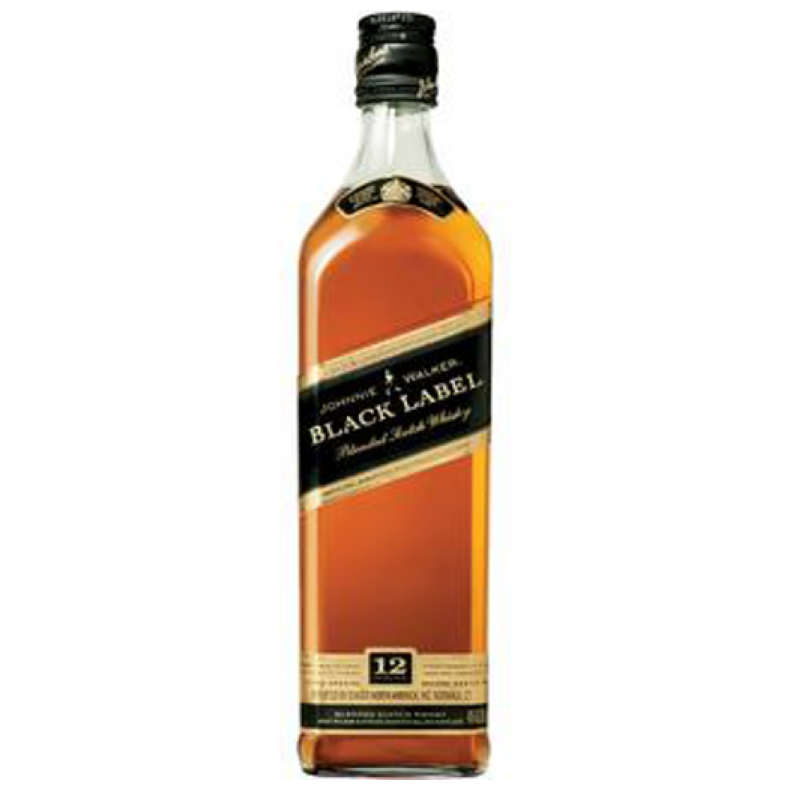

In [32]:
# Вывод первых 5 изображений
for img in Whisky_images[:5]:
    img_path = os.path.join(image_folder, img)
    image = mpimg.imread(img_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Дообучение модели

Пояснения:

1.Изображения загружаются из файла Whisky_images.pkl и создается список путей к этим изображениям.

2.Определяется класс CustomDataset, который наследует torch.utils.data.Dataset. Этот класс загружает изображения и применяет к ним трансформации.

3.Изображения изменяются до размера 128x128 пикселей и преобразуются в формат RGBA (4 канала).

4.Создается объект DataLoader, который загружает данные из кастомного датасета с размером батча 2 и перемешиванием данных.

5.Модель StableDiffusionPipeline загружается из локального хранилища и переносится на устройство (GPU, если доступно).

6.Определение оптимизатора и функции потерь: Используется оптимизатор Adam и функция потерь MSELoss.

7.Градиентный скалер используется для смешанной точности вычислений.

8.Модель обучается в течение 100 эпох. В каждой эпохе:

-модель переводится в режим обучения;

-инициализируется переменная для накопления потерь;

Для каждого батча изображений:

-изображения переносятся на устройство;

-обнуляются градиенты оптимизатора;

-генерируются случайные временные шаги и скрытые состояния;

-выполняется прямой проход через модель с использованием автокаста для смешанной точности;

-вычисляются потери и выполняется обратное распространение ошибки;

-обновляются параметры модели;

-накопленные потери обновляются и отображаются в индикаторе прогресса.

Этот процесс позволяет модели обучаться на изображениях и улучшать свои предсказания с каждой эпохой.


Используется функция потерь MSELoss (Mean Squared Error Loss), которая вычисляет среднеквадратичную ошибку между предсказанными изображениями и реальными изображениями.

criterion = nn.MSELoss()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

<ipython-input-43-2f3056040258>:52: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=True)
Epoch 1/10: 100%|██████████| 81/81 [00:36<00:00,  2.24it/s, loss=0.394]


Epoch [1/10], Loss: 0.3944627993084766


Epoch 2/10: 100%|██████████| 81/81 [00:36<00:00,  2.25it/s, loss=0.0538]


Epoch [2/10], Loss: 0.05383702948183557


Epoch 3/10: 100%|██████████| 81/81 [00:36<00:00,  2.24it/s, loss=0.00596]


Epoch [3/10], Loss: 0.005961812804108141


Epoch 4/10: 100%|██████████| 81/81 [00:36<00:00,  2.25it/s, loss=0.00278]


Epoch [4/10], Loss: 0.0027846086671127488


Epoch 5/10: 100%|██████████| 81/81 [00:36<00:00,  2.24it/s, loss=0.00195]


Epoch [5/10], Loss: 0.001954299241827548


Epoch 6/10: 100%|██████████| 81/81 [00:36<00:00,  2.25it/s, loss=0.00149]


Epoch [6/10], Loss: 0.0014867125960055416


Epoch 7/10: 100%|██████████| 81/81 [00:36<00:00,  2.25it/s, loss=0.00108]


Epoch [7/10], Loss: 0.0010788574280148303


Epoch 8/10: 100%|██████████| 81/81 [00:36<00:00,  2.24it/s, loss=0.000783]


Epoch [8/10], Loss: 0.0007825971099211731


Epoch 9/10: 100%|██████████| 81/81 [00:36<00:00,  2.25it/s, loss=0.00068]


Epoch [9/10], Loss: 0.0006801372884059853


Epoch 10/10: 100%|██████████| 81/81 [00:36<00:00,  2.24it/s, loss=0.000528]


Epoch [10/10], Loss: 0.0005275783375880026


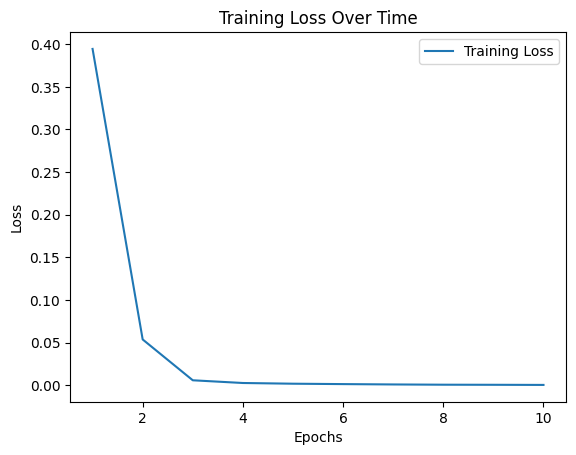

In [43]:
# Загрузка изображений из файла pkl и дообучение модели

# Загрузка списка изображений из файла pkl
with open('Whisky_images.pkl', 'rb') as f:
    Whisky_images = pickle.load(f)

# Путь к папке с изображениями
image_folder = '/content/drive/MyDrive/DS_Belhard_2/Homeworks/HW_4/dataset'

# Создание списка путей к изображениям

image_paths = [os.path.join(image_folder, img) for img in Whisky_images]

# Создание кастомного обработчика данных
class CustomDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = mpimg.imread(image_path)
        if self.transform:
            image = self.transform(image)
        return image

# Определение трансформации для изменения размера изображений и приведения к 4 каналам
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),  # Уменьшение размера изображений
    transforms.Lambda(lambda img: img.convert("RGBA")),
    transforms.ToTensor()
])

# Создание датасета и загрузчика данных
train_dataset = CustomDataset(image_paths, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)  # Уменьшение размера батча

# Загрузка модели из локального хранилища
pipe = StableDiffusionPipeline.from_pretrained("./stable_diffusion_model")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pipe = pipe.to(device)

# Определение оптимизатора и функции потерь
optimizer = optim.Adam(pipe.unet.parameters(), lr=5e-6)
criterion = nn.MSELoss()

# Использование градиентного скалера для смешанной точности
scaler = GradScaler(enabled=True)

# Обучение модели с индикатором прогресса
# Инициализация списка для хранения значений потерь
loss_values = []

# Обучение модели с индикатором прогресса
num_epochs = 10
for epoch in range(num_epochs):
    pipe.unet.train()
    running_loss = 0.0
    progress_bar = tqdm.tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    for i, images in enumerate(train_loader):
        images = images.to(device)
        optimizer.zero_grad()
        timesteps = torch.randint(0, 1000, (images.shape[0],), device=device).long()
        encoder_hidden_states = torch.randn(images.shape[0], 77, 768).to(device)  # Генерация случайных скрытых состояний
        with torch.amp.autocast(device_type='cuda', enabled=True):
            outputs = pipe.unet(images, timesteps, encoder_hidden_states).sample
            loss = criterion(outputs, images)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        progress_bar.update(1)
        progress_bar.set_postfix(loss=running_loss/(i+1))
    progress_bar.close()
    epoch_loss = running_loss / len(train_loader)
    loss_values.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}")

# Построение графика метрик
steps = list(range(1, num_epochs + 1))

plt.plot(steps, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.savefig('training_loss.png')
plt.show()


# Сохранение модели
pipe.save_pretrained("./stable_diffusion_model")

In [44]:
# Функция для генерации изображения
def generate_image(prompt):
  image = pipe(prompt).images[0]
  return image

In [48]:
# Пример использования
prompt_4 = "Whisky in Space"
image = generate_image(prompt_4)
# Сохранение изображения
image.save("generated_image_4.png")

  0%|          | 0/50 [00:00<?, ?it/s]

In [46]:
# Генерация изображения по текстовому запросу
prompt_5 = "Fairytale Forest Whisky"
image = pipe(prompt_5).images[0]

# Сохранение изображения
image.save("generated_image_5.png")

  0%|          | 0/50 [00:00<?, ?it/s]

In [49]:
# Генерация изображения по текстовому запросу
prompt_6 = "Winter Wonderland Whisky"
image = pipe(prompt_6).images[0]

# Сохранение изображения
image.save("generated_image_6.png")

  0%|          | 0/50 [00:00<?, ?it/s]

# Обучение только последних слоев модели

In [18]:
!pip install torch torchvision diffusers

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

<ipython-input-55-98fd07403e8d>:59: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=True)

Epoch 1/10:   0%|          | 0/81 [01:49<?, ?it/s]

Epoch 1/10: 100%|██████████| 81/81 [00:21<00:00,  3.71it/s, loss=0.804]


Epoch [1/10], Loss: 0.8037943140960034


Epoch 2/10: 100%|██████████| 81/81 [00:21<00:00,  3.80it/s, loss=0.737]


Epoch [2/10], Loss: 0.7369723732088819


Epoch 3/10: 100%|██████████| 81/81 [00:21<00:00,  3.78it/s, loss=0.678]


Epoch [3/10], Loss: 0.6782060434788834


Epoch 4/10: 100%|██████████| 81/81 [00:21<00:00,  3.78it/s, loss=0.622]


Epoch [4/10], Loss: 0.6223646453869196


Epoch 5/10: 100%|██████████| 81/81 [00:21<00:00,  3.79it/s, loss=0.566]


Epoch [5/10], Loss: 0.565896768996745


Epoch 6/10: 100%|██████████| 81/81 [00:21<00:00,  3.78it/s, loss=0.528]


Epoch [6/10], Loss: 0.5282329927991938


Epoch 7/10: 100%|██████████| 81/81 [00:21<00:00,  3.78it/s, loss=0.476]


Epoch [7/10], Loss: 0.4755470200821205


Epoch 8/10: 100%|██████████| 81/81 [00:21<00:00,  3.79it/s, loss=0.433]


Epoch [8/10], Loss: 0.4329027169280582


Epoch 9/10: 100%|██████████| 81/81 [00:21<00:00,  3.79it/s, loss=0.393]


Epoch [9/10], Loss: 0.39346425584804867


Epoch 10/10: 100%|██████████| 81/81 [00:21<00:00,  3.80it/s, loss=0.356]


Epoch [10/10], Loss: 0.35576693180166646


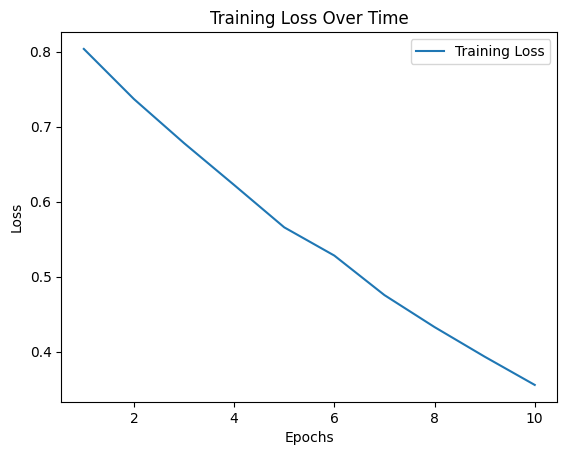

In [55]:
# Загрузка изображений из файла pkl и дообучение модели

# Загрузка списка изображений из файла pkl
with open('Whisky_images.pkl', 'rb') as f:
    Whisky_images = pickle.load(f)

# Путь к папке с изображениями
image_folder = '/content/drive/MyDrive/DS_Belhard_2/Homeworks/HW_4/dataset'

# Создание списка путей к изображениям
image_paths = [os.path.join(image_folder, img) for img in Whisky_images]

# Создание кастомного обработчика данных
class CustomDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = mpimg.imread(image_path)
        if self.transform:
            image = self.transform(image)
        return image

# Определение трансформации для изменения размера изображений и приведения к 4 каналам (RGBA)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),  # Уменьшение размера изображений
    transforms.Lambda(lambda img: img.convert("RGBA")),
    transforms.ToTensor()
])

# Создание датасета и загрузчика данных
train_dataset = CustomDataset(image_paths, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)  # Уменьшение размера батча

# Загрузка модели из локального хранилища
pipe = StableDiffusionPipeline.from_pretrained("./stable_diffusion_model")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pipe = pipe.to(device)

# Замораживание всех слоев, кроме последних нескольких
for param in pipe.unet.parameters():
    param.requires_grad = False

# Размораживание последних нескольких слоев
for param in list(pipe.unet.parameters())[-10:]:
    param.requires_grad = True

# Определение оптимизатора и функции потерь
optimizer = optim.Adam(filter(lambda p: p.requires_grad, pipe.unet.parameters()), lr=5e-6)
criterion = nn.MSELoss()

# Использование градиентного скалера для смешанной точности
scaler = GradScaler(enabled=True)

# Обучение модели с индикатором прогресса
# Инициализация списка для хранения значений потерь
loss_values = []

# Обучение модели с индикатором прогресса
num_epochs = 10
for epoch in range(num_epochs):
    pipe.unet.train()
    running_loss = 0.0
    progress_bar = tqdm.tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
    for i, images in enumerate(train_loader):
        images = images.to(device)
        optimizer.zero_grad()
        timesteps = torch.randint(0, 1000, (images.shape[0],), device=device).long()
        encoder_hidden_states = torch.randn(images.shape[0], 77, 768).to(device)  # Генерация случайных скрытых состояний
        with torch.amp.autocast(device_type='cuda', enabled=True):
            outputs = pipe.unet(images, timesteps, encoder_hidden_states).sample
            loss = criterion(outputs, images)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        progress_bar.update(1)
        progress_bar.set_postfix(loss=running_loss/(i+1))
    progress_bar.close()
    epoch_loss = running_loss / len(train_loader)
    loss_values.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}")

# Построение графика метрик
steps = list(range(1, num_epochs + 1))

plt.plot(steps, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.savefig('training_loss_.png')
plt.show()

# Сохранение модели
pipe.save_pretrained("./stable_diffusion_model")

In [63]:
# Пример использования
prompt_7 = "Whisky in Space"
image = generate_image(prompt_7)

# Сохранение изображения
image.save("generated_image_7.png")

  0%|          | 0/50 [00:00<?, ?it/s]

In [57]:
# Генерация изображения по текстовому запросу
prompt_8 = "Fairytale Forest Whisky"
image = generate_image(prompt_8)

# Сохранение изображения
image.save("generated_image_8.png")

  0%|          | 0/50 [00:00<?, ?it/s]

In [58]:
# Генерация изображения по текстовому запросу
prompt_9 = "Winter Wonderland Whisky"
image = generate_image(prompt_9)

# Сохранение изображения
image.save("generated_image_9.png")

  0%|          | 0/50 [00:00<?, ?it/s]